In [1]:
import scanpy as sc
import pandas as pd
import pickle
import time
import anndata
import sklearn.metrics
import statistics
import graph_tool.all as gt
%matplotlib notebook
%pylab

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('beta_parameter/adata_pbmc.h5ad')

In [3]:
g=pickle.load(open('beta_parameter/g_pbmc.pkl','rb'))

In [4]:
a=time.time()
state1=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state2=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state3=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
b=time.time()
b-a

397.2483389377594

In [5]:
pickle.dump(state1,open('new_alg_sets/pbmc/state1.pkl','wb'),2)
pickle.dump(state2,open('new_alg_sets/pbmc/state2.pkl','wb'),2)
pickle.dump(state3,open('new_alg_sets/pbmc/state3.pkl','wb'),2)

<IPython.core.display.Javascript object>


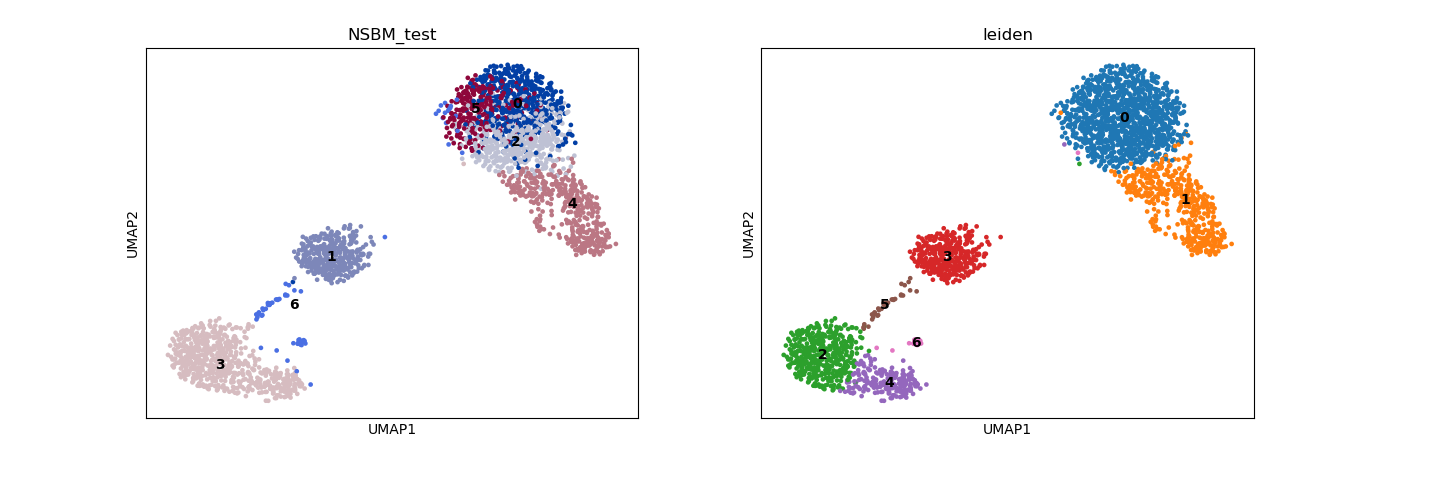

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
0,478,6,0,0,0,1,0
1,0,0,0,340,0,1,0
2,413,34,0,0,0,0,0
3,0,0,436,0,193,4,0
4,1,406,0,0,0,0,0
5,260,0,0,0,0,0,0
6,13,1,0,1,4,30,16


In [14]:
sc.tl.leiden(adata)

adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

In [18]:
state3.entropy()

224902.7341651312

##### scelgo il grafo con entropia maggiore (state3)

In [19]:
state=pickle.load(open('new_alg_sets/pbmc/state3.pkl','rb'))

# Anneal come ora (epsilon = 0.001, niter=10, nbreaks=2)

In [20]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

astate=state.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(astate,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0.001,mcmc_args=dict(niter=10)))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('new_alg_sets/pbmc/astate_e001_nm2_nit10.pkl','wb'),2)
astate

3590.947516679764


<NestedBlockState object, with base <BlockState object with 274 blocks (132 nonempty), for graph <Graph object, undirected, with 2638 vertices and 65573 edges, 1 internal edge property, at 0x7f0c635de090>, at 0x7f0c80126650>, and 10 levels of sizes [(2638, 132), (132, 24), (24, 8), (8, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f0c801265d0>

<IPython.core.display.Javascript object>


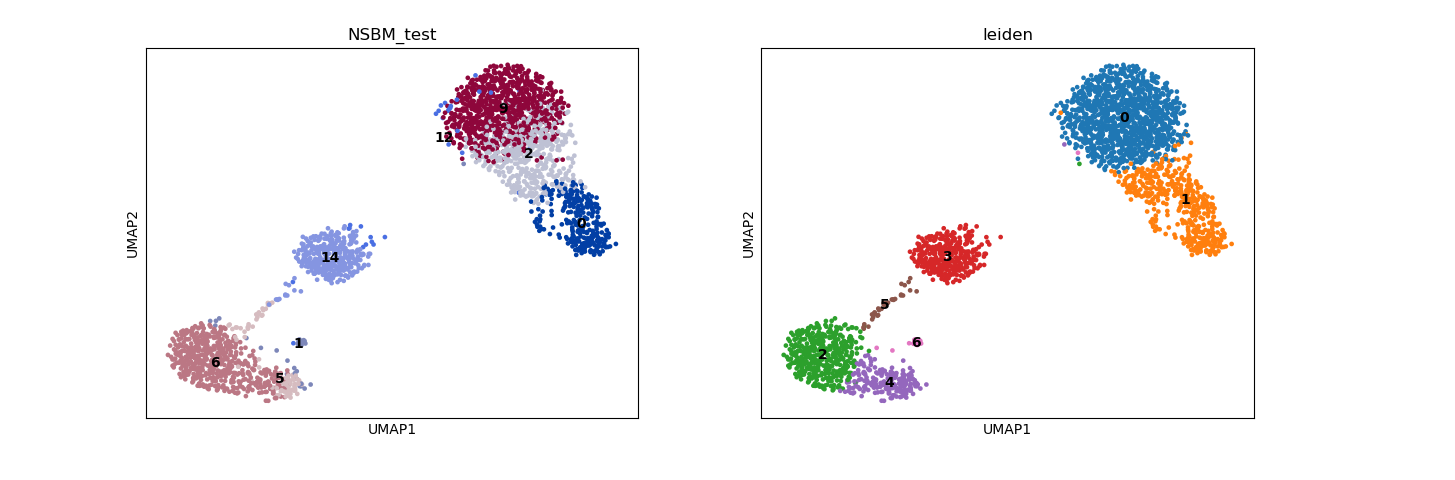

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
0,0,274,0,0,0,0,0
1,0,0,6,0,11,0,14
2,313,170,0,0,0,0,0
5,0,0,12,0,59,21,0
6,0,0,418,0,126,0,0
9,836,2,0,0,0,0,0
12,16,1,0,9,1,1,2
14,0,0,0,332,0,14,0


In [24]:
sc.tl.leiden(adata)

adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(astate.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

#### il grafo è venuto bene, ma ci ha messo 3590 secondi, per un subset di cellule piccolissimo
# sweep and Anneal niter=0, epsilon=0, nbreaks=2

In [25]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
a=time.time()
states=state.copy(bs=bs, sampling=True)
states.mcmc_sweep(niter=10000)
b=time.time()
bs = states.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
astate=states.copy(bs=bs, sampling=True)

gt.mcmc_anneal(astate,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0.001))
c=time.time()
d=b-a
e=c-b
print(d,e,d+e)
pickle.dump(state,open('new_alg_sets/pbmc/astate_e001_nm2_postsweep.pkl','wb'),2)
astate

129.8137993812561 365.1577160358429 494.971515417099


<NestedBlockState object, with base <BlockState object with 277 blocks (124 nonempty), for graph <Graph object, undirected, with 2638 vertices and 65573 edges, 1 internal edge property, at 0x7f0c635de090>, at 0x7f0c633c7290>, and 10 levels of sizes [(2638, 124), (124, 25), (25, 9), (9, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f0c796cbfd0>

<IPython.core.display.Javascript object>


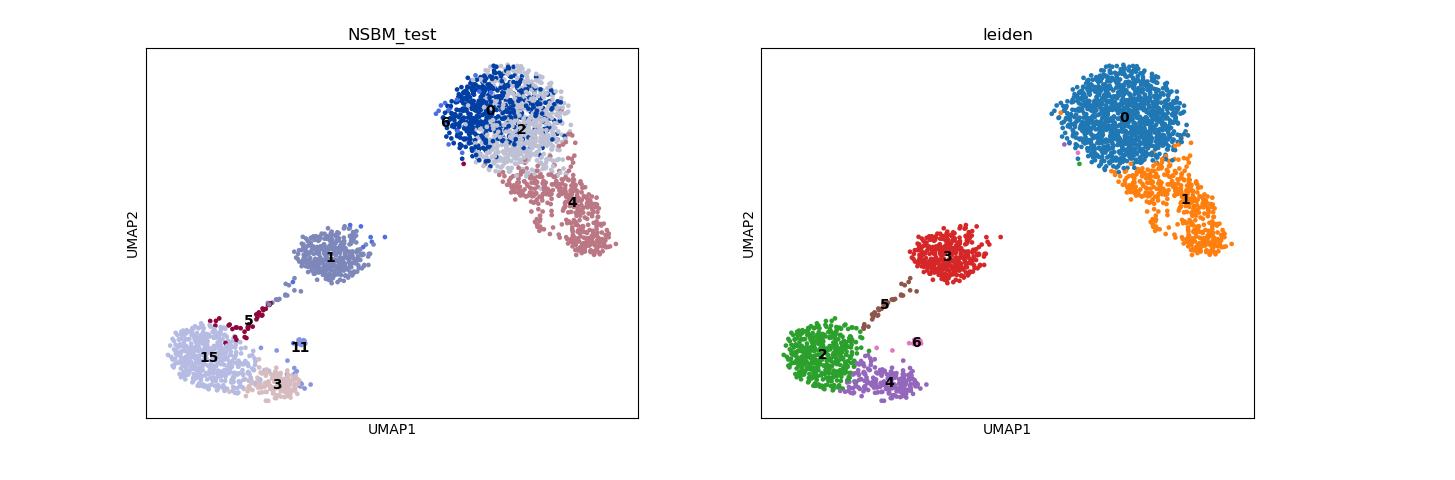

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
0,541,1,0,0,0,0,0
1,0,0,0,335,0,16,0
2,599,39,0,0,0,0,0
3,0,0,0,0,140,0,0
4,10,407,0,0,0,0,0
5,0,0,18,0,0,19,0
6,15,0,0,6,1,1,2
11,0,0,0,0,11,0,14
15,0,0,418,0,45,0,0


In [27]:
sc.tl.leiden(adata)

adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(astate.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)